In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [3]:
#導入kaggle上的資料集
data = pd.read_csv(r'/kaggle/input/tesla-stock-pricing-20172022/TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-18,25.350000,25.974001,25.178667,25.666668,25.666668,107820000
1,2017-09-19,25.333332,25.492666,24.904667,25.006666,25.006666,96778500
2,2017-09-20,24.866667,25.216667,24.738001,24.927334,24.927334,73786500
3,2017-09-21,24.993334,25.122000,24.300667,24.431999,24.431999,69273000
4,2017-09-22,24.432667,24.660000,23.392000,23.406000,23.406000,122391000


0    25.666668
1    25.006666
2    24.927334
3    24.431999
4    23.406000
Name: Close, dtype: float64

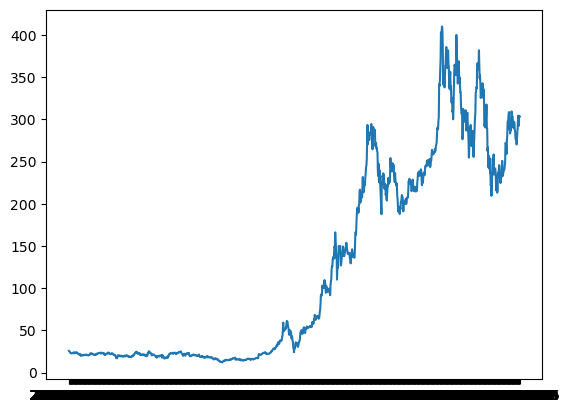

In [4]:
#整理資料取預測的值跟時間
df=data.reset_index()['Close']
plt.plot(data['Date'],df)
df.head()

In [5]:
# 資料 scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [6]:
#在測試相關的測試集中，發現區分training跟test會影響整體的預測
#時間唯有序列的數值，不可用隨機挑選，否則無法預測
#故以法A、法B、法C進行分群
#發現只有法A跟法C可進行

In [7]:
#法Ａ
#splitting dataset into train and test split
'''
training_size=int(len(df1)*0.7)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
'''
#法Ｂ
#這個方法錯誤！ 為什麼？ 提示：random_state
'''
from sklearn.model_selection import train_test_split
X = df1
y = df1
train_data, test_data, _, _ = train_test_split(X,y,test_size=0.3,random_state=0)
'''
#法Ｃ
#不要 shuffle
#https://stackoverflow.com/questions/43838052/how-to-get-a-non-shuffled-train-test-split-in-sklearn
from sklearn.model_selection import train_test_split
X = df1
y = df1
train_data, test_data, _, _ = train_test_split(X,y,test_size=0.3, shuffle=False)

In [8]:
#資料集型態
print(train_data.shape)
print(test_data.shape)

(881, 1)
(378, 1)


In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX = []
    dataY = []
    for i in range(len(dataset)-time_step-1):#N,n,t.....n=t+2
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----9
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(870, 10)
(870,)
(367, 10)
(367,)


In [11]:
# reshape input to be [samples, time steps, features] which is required for LSTM

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape), print(X_test.shape)

(870, 10, 1)
(367, 10, 1)


(None, None)

In [12]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [13]:
#創造LSTM魔法陣
#因為LSTM可行分層迭代，故具有記憶性
#此次設定為三層後收連為一值

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step,1)))#input10,output50
model.add(LSTM(50,return_sequences=True))#output50，input來自前面
model.add(LSTM(50))#output50，input來自前面
model.add(Dense(1))#收斂為1

#compile() 函数將一個字幅串編譯成字節代碼。
#compile(source, filename, mode[, flags[, dont_inherit]])
#以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [14]:
#nbatch_size=64(一般來說可省略，直接取決於電腦cpu)
#epocha = 回合
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 9s 86ms/step - loss: 0.0173 - accuracy: 0.0011 - val_loss: 0.0042 - val_accuracy: 0.0027
Epoch 2/100
14/14 [==============================] - 0s 10ms/step - loss: 0.0018 - accuracy: 0.0011 - val_loss: 0.0037 - val_accuracy: 0.0027
Epoch 3/100
14/14 [==============================] - 0s 10ms/step - loss: 9.0774e-04 - accuracy: 0.0011 - val_loss: 0.0036 - val_accuracy: 0.0027
Epoch 4/100
14/14 [==============================] - 0s 10ms/step - loss: 6.2266e-04 - accuracy: 0.0011 - val_loss: 0.0034 - val_accuracy: 0.0027
Epoch 5/100
14/14 [==============================] - 0s 9ms/step - loss: 5.1762e-04 - accuracy: 0.0011 - val_loss: 0.0034 - val_accuracy: 0.0027
Epoch 6/100
14/14 [==============================] - 0s 9ms/step - loss: 4.9564e-04 - accuracy: 0.0011 - val_loss: 0.0033 - val_accuracy: 0.0027
Epoch 7/100
14/14 [==============================] - 0s 9ms/step - loss: 5.5333e-04 - accuracy: 0.0011 - val_loss: 0.0048 - val_accura

In [15]:
#Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

12/12 [==============================] - 0s 3ms/step


In [16]:
#因為標準化過，
#轉換為原本資料型態
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [17]:
import math
from sklearn.metrics import mean_squared_error
#算performancem,越小越好
math.sqrt(mean_squared_error(y_train,train_predict))

85.79382394749067

In [18]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

265.5167885627885

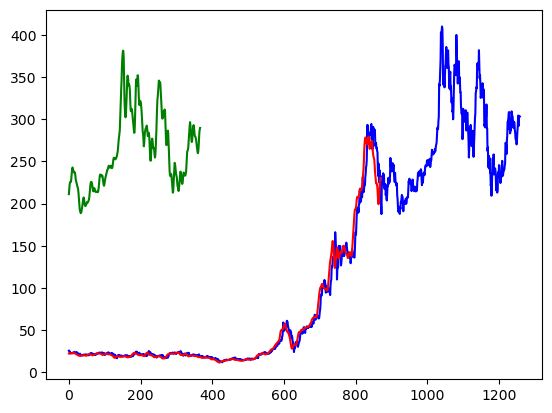

In [19]:
plt.plot(scaler.inverse_transform(df1),'blue')
plt.plot(train_predict,'red')
plt.plot(test_predict,'green')
plt.show()

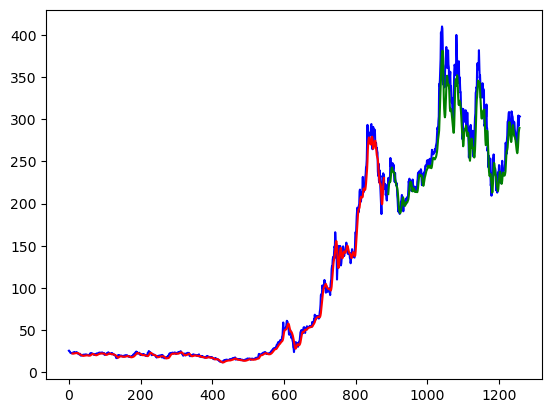

In [20]:
### Plotting 
# shift train predictions for plotting
time_step=10
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:len(train_predict)+time_step, :] = train_predict#平移
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(time_step*2)+1:len(df1)-1, :] = test_predict


# plot baseline and predictions

plt.plot(scaler.inverse_transform(df1),'blue')
plt.plot(trainPredictPlot,'red')
plt.plot(testPredictPlot,'green')
plt.show()

In [21]:
train_predict

array([[ 22.382587 ],
       [ 22.201103 ],
       [ 22.134338 ],
       [ 22.196375 ],
       [ 22.340746 ],
       [ 22.519182 ],
       [ 22.60747  ],
       [ 22.673578 ],
       [ 22.730227 ],
       [ 22.784933 ],
       [ 22.835234 ],
       [ 22.847626 ],
       [ 22.858217 ],
       [ 22.900955 ],
       [ 22.921627 ],
       [ 22.871698 ],
       [ 22.715282 ],
       [ 22.501497 ],
       [ 22.213045 ],
       [ 21.899546 ],
       [ 21.579617 ],
       [ 21.28327  ],
       [ 21.107191 ],
       [ 20.989672 ],
       [ 20.772474 ],
       [ 20.508007 ],
       [ 20.230034 ],
       [ 19.997355 ],
       [ 19.81796  ],
       [ 19.684214 ],
       [ 19.58955  ],
       [ 19.600933 ],
       [ 19.662258 ],
       [ 19.747509 ],
       [ 19.83559  ],
       [ 19.930803 ],
       [ 19.985653 ],
       [ 20.050938 ],
       [ 20.099342 ],
       [ 20.141916 ],
       [ 20.187477 ],
       [ 20.240917 ],
       [ 20.234007 ],
       [ 20.178617 ],
       [ 20.086653 ],
       [ 1

In [22]:
testPredictPlot

array([[         nan],
       [         nan],
       [         nan],
       ...,
       [287.75802612],
       [289.72247314],
       [         nan]])